In [1]:
#import package
import pandas as pd
import numpy as np

#import package visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#import outils statistiques  :
from scipy.stats import chi2_contingency

#Import des outils de preprocessing : 
from sklearn.preprocessing import OrdinalEncoder

#import package train test set :
from sklearn.model_selection import train_test_split, KFold

#import package model
from sklearn.neighbors import KNeighborsClassifier


#import package mesure precision model :
from sklearn.metrics import accuracy_score

#import pour grid search : 

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer #permet de trouver le modele faisant le meilleur score
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
titanic = pd.read_csv('train.csv')
df = titanic.copy()

# Demarche a suivre : 


1) Nettoyage des données

2) Analyse univariée et bivariée : inspection, visualisation et analyse des données (étude des  dépendances entre les variables, corrélation, test d'hypothèses...)

3) Prédiction de la colonne survived avec le knn_classifier

4) Mesure de la qualités de prévisions

## Récapitulatifs de l'Analyse du jeu de données :

- Modèle supervised ou unsupervised ? 
    - présence d'une **target** : **Survived**
- Caracteristiques des features :
    - Nombre : 11
        - qualitative : 
            - nominale : Name, Sex, Ticket, Cabin, Embarked (5)
        - quantitative : 
            - continue : Age, Fare (2)
            - discrète : PassengerID, Pclass, SibSP, Parch (4)

- Caracteristiques target : 
    - Survived : quantitative discrète



## Analyse du jeu de données : 

In [3]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
for i in titanic:
    print(i)

PassengerId
Survived
Pclass
Name
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [5]:
#Analyse du contenu des colonnes
print("Colonnes pouvant prendre moins de 20 valeurs différentes :\n")
for i in titanic:
    if titanic[i].nunique() <20 :
        print(i.upper(), ":\n", titanic[i].unique())
        
print("\nColonnes pouvant plus de 20 valeurs différentes : ")
for i in titanic:
    if titanic[i].nunique() >=20 :
        print(i.upper(), ":\n", titanic[i].unique()[:5])

Colonnes pouvant prendre moins de 20 valeurs différentes :

SURVIVED :
 [0 1]
PCLASS :
 [3 1 2]
SEX :
 ['male' 'female']
SIBSP :
 [1 0 3 4 2 5 8]
PARCH :
 [0 1 2 5 3 4 6]
EMBARKED :
 ['S' 'C' 'Q' nan]

Colonnes pouvant plus de 20 valeurs différentes : 
PASSENGERID :
 [1 2 3 4 5]
NAME :
 ['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry']
AGE :
 [22. 38. 26. 35. nan]
TICKET :
 ['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450']
FARE :
 [ 7.25   71.2833  7.925  53.1     8.05  ]
CABIN :
 [nan 'C85' 'C123' 'E46' 'G6']


#### Résumé : 
- Features :
    - Nombre : 11
    - qualitative :
         - nominale : Name, Sex, Ticket, Cabin, Embarked (5)
    - quantitative :
        - continue : Age, Fare (2)
        - discrète : PassengerID, Pclass, SibSP, Parch (4)
- Target :
    - quantitative discrète : Survived

## 1. Nettoyage de données (Imputing)
- Données manquantes ? 
    - Age : 19.87 %
    - Embarked : 0.22 %
    - Cabin : 77.1 % 

- Stratégie :
    - Données manquantes très élevée donc **suppression** de la colonne **Cabin**
    - **Age** : remplacement par la **moyenne**
    - **Embarked** : remplacement par **le mode**

In [6]:
for i in df:
    if df[i].isnull().sum()>0:
        print(f"{i} {round((df[i].isnull().sum()/df[i].shape[0])*100,2)} %") 

Age 19.87 %
Cabin 77.1 %
Embarked 0.22 %


Suppression de la colonne Cabin

In [7]:
df.drop("Cabin",axis = 1, inplace = True)

### Age : 

- 2 facon d'analyser : 


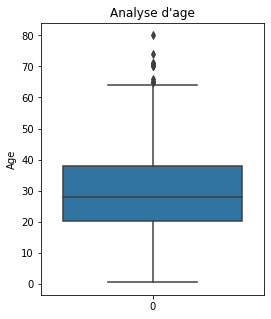

In [8]:
#1. avec un boxplot : 
plt.figure(figsize=(4,5))
sns.boxplot(data = df.Age)
plt.title("Analyse d'age")
plt.ylabel('Age')
plt.show()

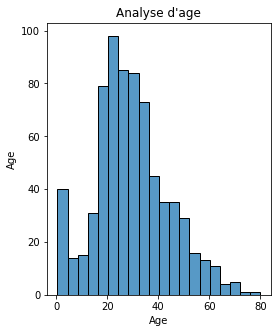

In [9]:
#2 avec un distplot : 
plt.figure(figsize=(4,5))
sns.histplot(df.Age)
plt.title("Analyse d'age")
plt.ylabel('Age')
plt.show()

**Observations** :
- peu d'outliers donc on peut remplacer par **la moyenne**

In [10]:
moy_age = df.Age.mean()
df.Age = df.Age.fillna(moy_age)

## Embarked : 

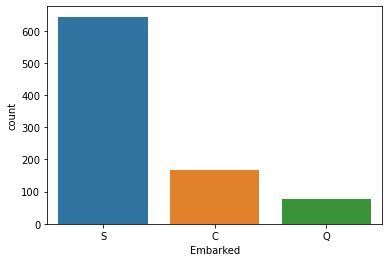

In [11]:
sns.countplot(df.Embarked)
plt.show()

**Embarked** est une variable **qualitative** donc on va remplacer par le **mode** (valeur la plus représentée de l'échantillon donc on va remplacer par **S** :

In [12]:
mode_embarked = df.Embarked.value_counts().idxmax()
df.Embarked = df.Embarked.fillna(mode_embarked)

In [13]:
#veribfication 
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

# 2. Analyse bi-variée entre la target et les features

- Pour rappel, la target est de type quantitative discrète

- Pour les features :
    - qualitative :
        - nominale : Name, Sex, Ticket, **Cabin : supprimée** , Embarked (**4**)
    - quantitative :
        - continue : Age, Fare (2)
        - discrète : PassengerID, Pclass, SibSP, Parch (4)

In [14]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

In [15]:
target = df.Survived

In [16]:
df = df.drop(['Survived'], axis = 1)

In [17]:
var_cat = ['PassengerId','Pclass','SibSp','Parch','Name','Sex','Ticket','Embarked']

In [18]:
var_cont = ['Age','Fare']

# 2.1 Survived vs variable categorique et discrètes : 

Entre deux variables categoriques, on utilise le test chi2 : 

In [19]:
chi2_p = {}
for i in var_cat:
    pval = chi2_contingency(pd.crosstab(df[i], target))[1] 
    chi2_p[i] = pval
sorted(chi2_p.items(), key=lambda x: x[1], reverse=False) #Trie les p_value de facon croissante
chi2_p

{'PassengerId': 0.484248151973633,
 'Pclass': 4.549251711298793e-23,
 'SibSp': 1.5585810465902147e-06,
 'Parch': 9.703526421039997e-05,
 'Name': 0.484248151973633,
 'Sex': 1.1973570627755645e-58,
 'Ticket': 0.01152729601163775,
 'Embarked': 2.3008626481449577e-06}

Nous allons récupérer uniquement les variables pour lesquelles pvalues<0.05: 

In [20]:
var_cat_final = []
var_cat_supprime = []

for i in chi2_p:
    if chi2_p[i]<0.005:
        var_cat_final.append(i)
    else:
        var_cat_supprime.append(i)
print(" On garde les variables suivante : ", var_cat_final)
print(" On supprime les variables suivante : ", var_cat_supprime)


 On garde les variables suivante :  ['Pclass', 'SibSp', 'Parch', 'Sex', 'Embarked']
 On supprime les variables suivante :  ['PassengerId', 'Name', 'Ticket']


In [21]:
df = df.drop(var_cat_supprime, axis = 1)

# 2.1 Survived vs variable continues :
- Nous sommes dans le cas ou nous avons une variables discrètes vs variables continues : **boxplot**

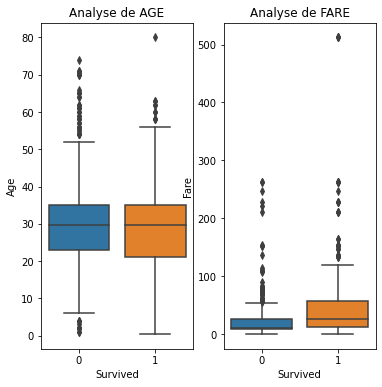

In [22]:
fig, axe = plt.subplots(1,2,figsize=(6,6))
for i in range(len(var_cont)):
    ax = sns.boxplot(y = var_cont[i], x = target,  ax=  axe[i],
                 data=df)
    ax.set_title(f'Analyse de {var_cont[i].upper()}')
plt.show()

**Observations** : 
- La mediane ne varie pas lorsqu'on regarde la survie en fonction de l'âge
- La mediane varie lorsqu'on regarde la survie en fonction de Fare 

**Interprétation** :
* L'âge n'a pas d'influence sur la survie tandis que Fare en a. 

**Conclusion** :

- Age et Survived sont des **variables indépendantes**
    - On rejette H0(dépendance des variables) et on accepte H1.

- Fare et Survived sont des **variables dépendantes**
    - On rejette H1(indépendances des variables) et on accepte H0


In [23]:
#on peut supprimer la colonne age de df :
df.drop('Age', axis = 1, inplace = True)

In [24]:
#On garde les colonnes suivantes :
df.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,3,male,1,0,7.2500,S
1,1,female,1,0,71.2833,C
2,3,female,0,0,7.9250,S
3,1,female,1,0,53.1000,S
4,3,male,0,0,8.0500,S


# 3) Prédiction de la colonne survived avec le knn_classifier

Afin de pouvoir utiliser notre modèle dans les meilleures conditions possibles, il va falloir préparer notre jeu de donnée :

## 3 Préparation du jeu de données : 
On va procéder par étapes dans l'ordre suivant : 
- Pour les variables qualitatives/discrètes : **Encodage**
- Séparation du jeu de donnée en deux : train et test set
- Pour les variables continues : **Normalisation** ( rappel : toutes les données sont normalisées avec la moyenne et l'ecart type du **train**


## 3.1 Encodage des variables :

In [25]:
#Nous avons vu au travers de df qu'il y a deux variables a encoder : Sex et Embarked
enc = OrdinalEncoder()
df[['Sex','Embarked']] = enc.fit_transform(df[['Sex','Embarked']])

In [26]:
df.head(1)

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,3,1.0,1,0,7.25,2.0


## 3.2 Création du train et test set :

**Remarque :**
- si on utilise la cross_validation, on ne fait pas de train_test_split, donc on normalisera pas les données en fonction du train ,mais on normalise **tout** le dataframe

In [27]:
X_train, X_test, y_train, y_test  = train_test_split(df, target, test_size=0.2, random_state=42)

## 3.3 Normalisation des données 

In [28]:
#normalisation du train : 
normalized_train = (X_train-X_train.mean())/X_train.std()
#normalisation du test : 
normalized_test = (X_test-X_train.mean())/X_train.std()

In [29]:
#On remet les valeurs qui n'auraient pas dû etre normalisée (ici seul Fare doit etre normalisé ) : 
#Dans le train :
normalized_train[var_cat_final] = df[var_cat_final]
#Dans le test :
normalized_test[var_cat_final] = df[var_cat_final]

In [30]:
normalized_test

,Pclass,Sex,SibSp,Parch,Fare,Embarked
709,3,1.0,1,1,-0.333666,0.0
439,2,1.0,0,0,-0.424985,2.0
840,3,1.0,0,0,-0.474533,2.0
720,2,0.0,0,1,0.007961,2.0
39,3,0.0,1,0,-0.410713,0.0
...,...,...,...,...,...,...
433,3,1.0,0,0,-0.489927,2.0
773,3,1.0,0,0,-0.488003,0.0
25,3,0.0,1,5,-0.023067,2.0
84,2,0.0,0,0,-0.424985,2.0


Maintenant nous pouvons utiliser les données pour notre modèle : 

# Prédiction de la colonne survived avec le knn_classifier :


In [58]:
knn = KNeighborsClassifier()
knn.fit(normalized_train, y_train)
y_pred = knn.predict(normalized_test)

# 4) Mesure de la qualités de prévisions

In [66]:
precision = accuracy_score(y_test,y_pred)
print(f"Precision du modèle : {round(precision*100,1)} %")

Precision du modèle : 80.4 %


Nous pouvons tenter d'améliorer notre modèle en réglant les hypers parametres, utilisons le GridSearchCV afin de trouver les hyperparametres qui maximises nos chances d'obtenir le meilleur score : 

In [60]:
#Dictionnaire des hypers-parametres 
param_grid={'n_neighbors': np.arange(2,50), 
            'metric':['euclidean','manhattan', 'minkowski']}

#instanciation du modèle : 
grid=GridSearchCV(estimator=KNeighborsClassifier(),
                  param_grid=param_grid,
                  scoring=make_scorer(accuracy_score))
#entrainement du modèle 
grid.fit(X = normalized_train,y = y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             scoring=make_scorer(accuracy_score))

In [61]:
print("Best estimator :", grid.best_estimator_)

model = grid.best_estimator_ # On recupere le modèle ayant les meilleurs caracteristiques (grace au make_scorer qui donne
#les meilleurs scoring pour chaque hyper parametres testés)
predictions = model.predict(X =  normalized_test)

Best estimator : KNeighborsClassifier(metric='manhattan', n_neighbors=12)


In [67]:
accuracy = accuracy_score(y_test, predictions)

print("accuracy : ", round((accuracy)*100,1), "%")

accuracy :  79.9 %


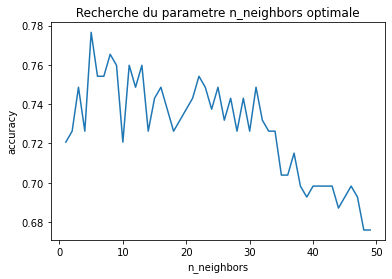

In [36]:
#autre methode pour trouver l'hyper parametre n_neigbors optimale :
neighbors = range(1,50)
score = []
for i in neighbors:
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X = X_train,y = y_train)
    y_pred = model.predict(X_test)
    mse = accuracy_score(y_test,y_pred)
    score.append(mse)
ax = sns.lineplot(x = neighbors, y = score)   
ax.set_title(" Recherche du parametre n_neighbors optimale ")
ax.set_xlabel('n_n
              eighbors')
ax.set_ylabel('accuracy')
plt.show()

# Prédictions sur le fichier test.csv 

In [37]:
titanic_test = pd.read_csv('test.csv')

In [38]:
X_test_final = titanic_test[X_train.columns] #recuperation des memes colonnes que pour le fichier train

## Preprocessing : 


In [39]:
X_test_final.isnull().sum()

Pclass      0
Sex         0
SibSp       0
Parch       0
Fare        1
Embarked    0
dtype: int64

In [40]:
X_test_final.Fare.dtypes

dtype('float64')

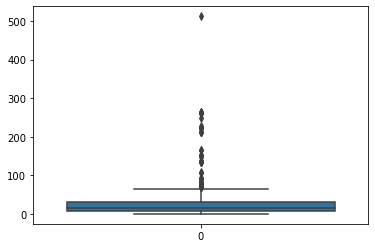

In [41]:
sns.boxplot(data = X_test_final.Fare)
plt.show()


**Observations :**: 
presence de beaucoup d'outliers donc on remplace par la **mediane**

In [42]:
#1. imputing
X_test_final.Fare.fillna(X_test_final.Fare.median(), inplace=True)

In [43]:
X_test_final.head(2)

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,3,male,0,0,7.8292,Q
1,3,female,1,0,7.0000,S


In [44]:
#2. Encodage 
X_test_final[['Sex','Embarked']] = enc.fit_transform(X_test_final[['Sex','Embarked']])

In [45]:
X_test_final.head(2)

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,3,1.0,0,0,7.8292,1.0
1,3,0.0,1,0,7.0000,2.0


In [46]:
#3. Normalisation : 
normalized_test_final = (X_test_final-X_train.mean())/X_train.std()

In [47]:
normalized_test_final.head(2)

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0.812463,0.723801,-0.470392,-0.479005,-0.476377,-0.730251
1,0.812463,-1.379654,0.379656,-0.479005,-0.492332,0.563129


In [71]:
#on remet les données qui ne doivent pas etre normalisées : 
normalized_test_final[var_cat_final] = X_test_final[var_cat_final]

In [73]:
normalized_test_final.head(2)

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,3,1.0,0,0,-0.476377,1.0
1,3,0.0,1,0,-0.492332,2.0


In [50]:
#4. Prediction 

In [80]:
param_grid={'n_neighbors': range(2,100), 
            'metric':['euclidean','manhattan', 'minkowski']}
#instanciation du modèle : 
grid=GridSearchCV(estimator=KNeighborsClassifier(),
                  param_grid=param_grid,
                  scoring=make_scorer(accuracy_score),)
grid.fit(X = normalized_train,y = y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(2, 100)},
             scoring=make_scorer(accuracy_score))

In [86]:
model = grid.best_estimator_
model

KNeighborsClassifier(metric='manhattan', n_neighbors=12)

In [82]:
predict_final = model.predict(X = normalized_test_final)

### Pour poster le predict et connaitre notre score sur kaggle : 

Il faut regarder le fichier qu'on a aussi decompresser avec le train et test qui s'appelle : **gender_submission.csv**

In [83]:
pd.read_csv('gender_submission.csv').head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Il faut donc que notre fichier final ressemble a cela, sauf qu'il faut que passengerId soit en **index** :

In [84]:
Data_final_ = pd.DataFrame({"Survived": predict_final}, index=titanic_test.PassengerId)
Data_final_.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


In [85]:
#export en csv : 
Data_final_.to_csv(path_or_buf='Export_final_titanic_KNN.csv', 
                   header=True, sep= ',',)

### Sur kaggle : 
https://www.kaggle.com/competitions/titanic/overview/evaluation

on clique sur le "submit predictions" et on soumet le csv qu'on a creer ci-dessus

Scoring kaggle : **0.75837**